# Programming exercise 8: The AKLT model and matrix product states

Due on Monday, 24.12.2018, 23.59h

### Total: 100 points

In [1]:
# load standard libraries

import scipy.sparse as sparse
import scipy.sparse.linalg as sLA
import scipy.linalg as scLA
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 1: Solving the AKLT model with exact diagonalization (25 points)

This time we want to study a quantum many-body model for spins known as the AKLT model which was introduced in the 80's to explore the Haldane conjecture(see https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799). It has a couple of remarkable features that will allow us to use it as playground for testing the basic ideas surrounding matrix product states. As additional practice on how to build general spin models and exact diagonalization, we will start by solving it here by numerical means and then compare the result to some theoretical predictions. You can use some of the code from the last exercise as a basis but make sure to modify the operators as now we are working with spin 1!  

As mentioned, this is a spin 1 model and it lives in a one dimensional chain with periodic boundary conditions (using the correct boundary condition is critical here) and the Hamiltonian is given by:

$$
H=J\sum_{i=0}^{N-1}\left(\frac{1}{3} +\frac{1}{2}S^{(i)}\cdot S^{(i+1)}+\frac{1}{6}(S^{(i)}\cdot S^{(i+1)})^2\right)
$$
Remenber that, due to the periodic boundary conditions, the Nth spin is identified with 0th spin. $S^{(i)}$ denotes the vector of spin sperators $(S_x^{(i)}, S_y^{(i)}, S_z^{(i)})$. It might be convenient to use the following representation for the spin their products:
$$
S^{(i)}\cdot S^{(i+1)} = S_z^{(i)} S_z^{(i+1)}+\frac{1}{2}\left(S_+^{(i)}S_-^{(i+1)}+S_-^{(i)}S_+^{(i+1)}\right)
$$
where the relevant spin 1 spin operators are $S_z=-|-1\rangle\langle-1| + |+1\rangle\langle+1|$, $S_+=\sqrt{2}(|+1\rangle\langle 0| + |0\rangle\langle -1|)$ and $S_- = S_+^\dagger$ (with $|s\rangle$ denoting the basis states in the $S_z$ eigenbasis).

Build the Hamiltonian in the standard product basis ($J$ is just a global energy scale and can be set to 1).

First you can test your implementation by calculating the ground state energy and making sure it is zero as this is the theoretical prediction. Another test is the magnetization on the z direction which should also be zero.

Once you are confident that your code is working you should compute the energy gap between ground and first excited state for a couple of system sizes $N$ and see how it behaves. Is the system gapped? This question is directly related to the Haldane conjecture.

Finally, compute the correlation function $\langle S_z^{(i)}S_z^{(i+r)} \rangle$ as a function of $r$ and compare to the theoretical result:
$$
\langle S_z^{(i)}S_z^{(i+r)}\rangle \propto \left(\frac{-1}{3}\right)^r
$$

It probably won't look so good as the exact diagonalization is not the best tool to study this but you should get some agreement.


Optional: Investigate what happend for open boundary conditions and see if there is any qualitative difference.

In [2]:
plus=np.array([1,0,0])
null=np.array([0,1,0])
minus=np.array([0,0,1])
#build spin operators
sz=-np.outer(minus,minus)+np.outer(plus,plus)
sp=np.sqrt(2)*(np.outer(plus,null)+np.outer(null,minus))
sm=np.transpose(sp)

In [3]:
# spin operators
# sparse spin operators
szSp = sparse.csr_matrix(sz)
spSp = sparse.csr_matrix(sp)
smSp = sparse.csr_matrix(sm)
oneSp = sparse.identity(3)
# function that builds all single spin operators
def BuildSingleSpinOps(N):
    szi=[]
    spi=[]
    smi=[]
    # build the single spin operators
    for i in range(N):
        szi.append( sparse.kron(sparse.kron(sparse.identity(3**(N-i-1)),szSp),sparse.identity(3**i)) )
        spi.append( sparse.kron(sparse.kron(sparse.identity(3**(N-i-1)),spSp),sparse.identity(3**i)) )
        smi.append( sparse.kron(sparse.kron(sparse.identity(3**(N-i-1)),smSp),sparse.identity(3**i)) )
        
    return szi, spi, smi

# Build the transverse field ising Hamiltonian with periodic boundaries
def Build_H_TFIM(N):
    Hmat = N/3*sparse.identity(3**N)
    for i in range(N):
        product=Szis[i]@Szis[(i+1)%N] +1/2*(Spis[i]@Smis[(i+1)%N]+Smis[i]@Spis[(i+1)%N])
        Hmat = Hmat +1/2*(product)+1/6*product@product
    return Hmat



## Assurance of working code

In [4]:
N = 10
dim = 3**N

Szis, Spis, Smis = BuildSingleSpinOps(N)

# calculate the ground state and compare to analytical result
Hmat = Build_H_TFIM(N)
eigval,eigvek=sLA.eigsh(Hmat,k=2,which="SA")
groundstate=eigvek[:,0]
print('ground state energy: %e'%sLA.eigsh(Hmat,k=3,which='SA')[0][0])



ground state energy: 7.501388e-16


This is small enough to be counted as zero in our numerical boundaries.

## Gap calculations

In [5]:
Ns=np.linspace(4,12,8,dtype=int)

dif=np.zeros(len(Ns))
groundstatefct=[]
for i in range(len(Ns)):
    N=int(Ns[i])
    dim=3**N
    Szis, Spis, Smis = BuildSingleSpinOps(int(N))
    Hmat=Build_H_TFIM(int(N))
    eigval,eigvec=sLA.eigsh(Hmat,k=2,which="SA")
    dif[i]=eigval[1]-eigval[0]
    groundstatefct.append(eigvec[:,0])
    print('progress: %i/%i'%((i+1),len(Ns)),end='\r')

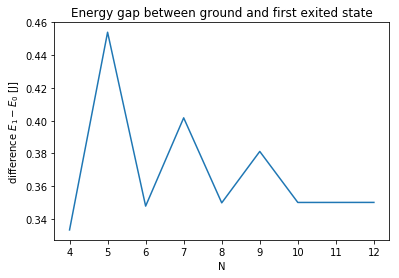

In [6]:
#plotting the energy gap between ground state and first excited state for different spin numbers
plt.plot(Ns,dif)
plt.xlabel('N')
plt.ylabel('difference $E_1-E_0$ [J]')
plt.title('Energy gap between ground and first exited state')
plt.show()

As visible the energy gap between ground state and first excited state fluctuates at first, but with higher N converges against $\approx 0.35$

## Expectation value

In [7]:
N = 10
Szis, Spis, Smis = BuildSingleSpinOps(N)
def expectationvalue(j,r,state):
    return np.transpose(state)@Szis[j]@Szis[(j+r)%N]@state

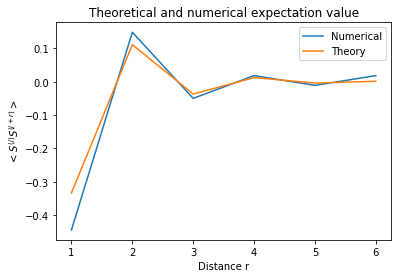

In [8]:
#calculating the groundstate again
Hmat = Build_H_TFIM(N)
eigval,eigvek=sLA.eigsh(Hmat,k=2,which="SA")
groundstate=eigvek[:,0]
r=np.arange(1,7,1)
expectval2=[]

for el in r:
    #2 as this is our first spin, el refers to the difference to the second element we are investigating and 10 is the
    #total spin number
    expectval2.append(expectationvalue(2,el,groundstate))

plt.plot(r,expectval2,label="Numerical")
plt.title("Theoretical and numerical expectation value")
plt.xlabel("Distance r")
plt.ylabel("$<S^{(j)} S^{(j+r)}>$")
plt.plot(r,(-1/3)**r,label="Theory")
plt.legend()

As can be seen the numerical solution resemble the theoretical dependency very well.

### Exercise 2: Entanglement in the phase diagram (25 points)

Now we are going to look at entanglement in the AKLT model but to make things more interesting we add a paramenter $\theta$ to the Hamiltonian:
$$
H=-J\sum_{i=0}^{N-1}\left(\frac{cos(\theta)}{3 cos(\theta_{0})} +\frac{cos(\theta)}{2 cos(\theta_{0})}S^{(i)}\cdot S^{(i+1)}+\frac{sin(\theta)}{6 cos(\theta_{0})}(S^{(i)}\cdot S^{(i+1)})^2\right)
$$
where $\theta_0 = \text{arctan}(1/3)$ is a special angle that allow us to go back to the original Hamiltonian with $\theta=\theta_0$.


Study what happens to the gap of the system as you change $\theta$, moving away from $\theta_0$, and interpret your results. After this you should look at the entanglement of the ground state for different $\theta$ taking into account your conclusions about the gap. What happens to the entanglement entropy and the schmidt rank as $\theta$ changes?

Tip: a nice trick to compute partial traces is to use the function reshape() as it allows you to rewrite your state as a matrix in the way required for a Schmidt decomposition. After that all you need to do to get the entanglement spectrum is perform a svd (also available in the usual places) and look at the singular values.

In [9]:
def Build_H_TFIMth(N,th):
    
    Hmat = N*np.cos(th)/(np.cos(np.arctan(1/3))*3)*sparse.identity(3**N)
    for i in range(N):
        product=Szis[i]@Szis[(i+1)%N] +1/2*(Spis[i]@Smis[(i+1)%N]+Smis[i]@Spis[(i+1)%N])
        Hmat = Hmat +np.cos(th)/(np.cos(np.arctan(1/3))*2)*(product)+np.sin(th)/(np.cos(np.arctan(1/3))*6)*product@product
    return Hmat


## Gap calculation

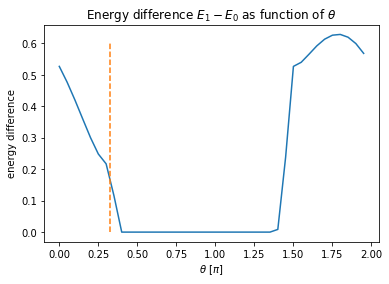

In [10]:
dif=[]
groundstates=[]
N=4
thetas=np.arange(0,2*np.pi,np.pi/20)
Szis, Spis, Smis = BuildSingleSpinOps(N)

for th in thetas:
    Hmat=Build_H_TFIMth(N,th)
    eigval,eigvec=sLA.eigsh(Hmat,k=3,which="SA")
    dif.append(eigval[1]-eigval[0])
    groundstates.append(eigvec[:,0])
plt.plot(thetas/np.pi,dif)
plt.xlabel(r'$\theta$ [$\pi$]')
plt.ylabel('energy difference')
plt.title(r'Energy difference $E_1-E_0$ as function of $\theta$')

y=np.linspace(0,0.6,100)
z=np.ones(100)
plt.plot(z*np.arctan(1/3),y,linestyle="--")

In the diagram a vanishing of the gap is visible as $\theta$ moves further away from $\theta_0$, telling us that the groundstate and first excited merge.

## Schmidt Rank and Entangelment Entropy

Note: The calculations below are probably not correct as we were not sure where to split the system. It was done in this case for a N=4 spin system. 
The Schmidt Rank is the number of non zero elements of the S Matrix in the SUV representation and the Entropy 
$S=-\sum_r S_r^2 + log(S_r^2)$ with $S_r$ being the non zero S Matrix Values.

In [11]:
#Calculating the Schmidt rank 
def SchmidtRank(state):
    #reshaping the matrix
    Matstate = np.reshape(state,(3**2,3**2))
    
    u,s,v = npla.svd(Matstate)
    rank=s[abs(s)>1e-14]
    return len(rank)
    
def Entropy(state):
    
    Matstate= np.reshape(state,(3**2,3**2))
    
    u,s,v = npla.svd(Matstate)
    S = s[s>2e-14]
    return -1* np.sum(S*S+np.log(S*S))


In [12]:
Schmidtrank=[]
Entropies=[]
for state in groundstates:
    Schmidtrank.append(SchmidtRank(state))
    Entropies.append(Entropy(state))

Text(0,0.5,'rank')

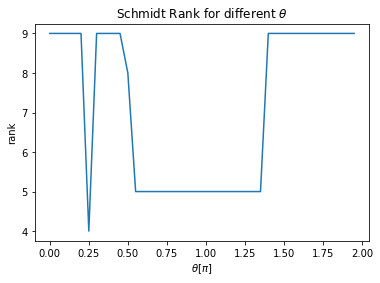

In [13]:
plt.plot(thetas/np.pi,Schmidtrank)
plt.title(r"Schmidt Rank for different $ \theta $")
plt.xlabel(r"$ \theta  [\pi]$")
plt.ylabel("rank")

Text(0,0.5,'Entropy')

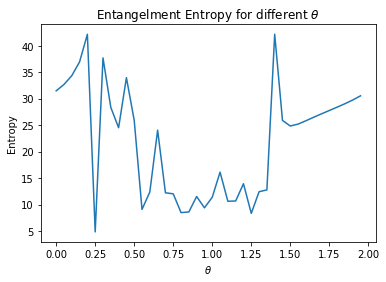

In [14]:
plt.plot(thetas/np.pi,Entropies)
plt.title(r"Entangelment Entropy for different $\theta$")
plt.xlabel(r"$ \theta$")
plt.ylabel("Entropy")

Both plots show interesting behaviours in the region of the vanishing ground state gap. 

### Exercise 3: MPS description (50 points)

Finally we will use the MPS machinery and explain why we chose to study the AKLT model (besides the fact that it is a pretty cool model :)). Usually for any given Hamiltonian it is necessary to apply a (complicated) procedure to find a good MPS aproximation for the ground states but the AKLT ground states is special in that it admits an exact MPS description so we can directly apply the tensor network techniques to it! The representation only requires bond dimension 2 and is given by the following 2x2 matrices:
$$
A_{+1}=\sqrt{\frac{2}{3}} \sigma_+\\
A_{0}=-\sqrt{\frac{1}{3}} \sigma_z\\
A_{-1}=-\sqrt{\frac{2}{3}} \sigma_-\\
$$

Show that this really gives the ground state by comparing it to the states you got from exact diagonalization. To do so you should use the expression for MPS ansatz to reconstruct the corresponding state in your basis
$$
|\psi_{\text{mps}}\rangle = \sum_{s_i} Tr(A_{s_0}A_{s_1}\dots A_{s_{N-1}})|s_0 s_1 \dots s_{N-1}\rangle
$$
and compute the overlap $\langle\psi_{\text{ed}}|\psi_{\text{mps}}\rangle$ with the exact diagonalzation ground state. Of course, this is not very smart as we are using our efficiennt MPS representation to reconstruct the inefficient ED representation, but it is a good sanity check nonetheless. 

You might notice a small deviation on the overlap. This comes from the fact that the MPS state is not normalized and you can see this by computing the norm directly from the matrices:
$$
\langle\psi_{\text{mps}}|\psi_{\text{mps}}\rangle = Tr(E^n)
$$
where
$$
E = \sum_s A_s\otimes A_s^*\\
$$
is the local matrix corresponding to the identity operator. To speed up this calculation you can diagonalize E so that you only need to compute powers of the eigenvales and not the actual matrix. Show that the deviation from 1 is small and vanishes exponentially for large systems.

Now, for the real benefits of the MPS, let's compute the correlation function $\langle S_z^{(i)}S_z^{(i+r)}\rangle$ from exercise 1. This can be done for very large systems by simply replacing two E matrices in the expression for the norm with
$$
E_z = \sum_{s,s'}\langle s|S_z|s'\rangle A_s\otimes A_{s'}^*
$$
which is the local matrix for $S_z$. Think about the correct position where the $E_z$ should go and use this to compute the correlation function. Compare the results to the theoretical prediction mentioned in the first exercise.

Optional: The AKLT model has a hidden order that manifests it self through a string operator:
$$
\langle S_z^{(i)}\,\exp\left[\sum_{i<k<j}i \pi S_z^{(k)}\right] \,  S_z^{(j)}\rangle
$$
Compute this order parameter and show that it maintains a constant value for $|i-j|>2$

## Creation of the needed matrices

In [15]:
#defining the matrices
Ap=np.array([[0,np.sqrt(2/3)],[0,0]])
A0=-1/np.sqrt(3)*np.array([[1,0],[0,-1]])
Am=np.array([[0,0],[-np.sqrt(2/3),0]])

ApSp = sparse.csr_matrix(Ap)
A0Sp = sparse.csr_matrix(A0)
AmSp = sparse.csr_matrix(Am)
mat=[ApSp,A0Sp,AmSp]

In [16]:
#creating an empty matrix
Em = sparse.csr_matrix((4,4))

#adding up the matrixes
for matrix in mat:
    Em= Em + sparse.kron(matrix,np.transpose(matrix))

#calculating Ez, can be done as below, as only the +1 and -1 states contribute due to the orthogonal basis and 0 eigval
#of the 0 state leaving all other possibilites to fall out(equal 0)
Ez = sparse.kron(mat[0],np.transpose(mat[0]))-sparse.kron(mat[2],np.transpose(mat[2]))

Note: The basis representation was not done

## Overlap and Expectation values

In [17]:
#calculating the eigvalues
def trace(N):
    eigval,eigvek=scLA.eigh(Em.todense())
    #start trace by adding eigvalues
    overlap=0
    for i in range(len(eigval)):
        overlap+= eigval[i]**N
    return overlap

#calculation of the expected value j refers to the first spin and r the diference to the second and N the number of
#total spins

def expect(j,r,N):
    i=j+r
    sol=Em**(j-1)@Ez@Em**(i-j-1)@Ez@Em**(N-i)
    
    return np.trace(sol.toarray())
#reference array for plotting

Text(0.5,1,'Theoretical overlap')

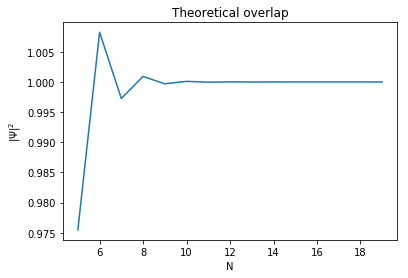

In [18]:
Ns=np.arange(5,20,1)
overlapsi=[]
for xi in Ns:
    one=trace(xi)
    overlapsi.append(one)
plt.plot(Ns,abs(np.array(overlapsi)**2))
plt.xlabel("N")
plt.ylabel("$|\Psi|^2$")
plt.title("Theoretical overlap")

As can be seen, the theoretical overlap converges to 1 for larger N.

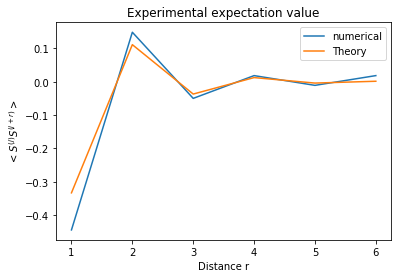

In [19]:
#calculating the overlap using the mps method
r=np.arange(1,7,1)
expectval=[]

for el in r:
    #2 as this is our first spin, el refers to the difference to the second element we are investigating and 10 is the
    #total spin number
    expectval.append(expect(2,el,10))

plt.plot(r,expectval,label="numerical")
plt.title("Experimental expectation value")
plt.xlabel("Distance r")
plt.ylabel("$<S^{(j)} S^{(j+r)}>$")
plt.plot(r,(-1/3)**r,label="Theory")
plt.legend()

As can be seen the mps representation gives us a great possibility to calculate expectation values. The obtained results show the same trend as the theoretical reference.